# A demonstration of how to visualize the gene-level results for multi-trait analysis

In [1]:
import os
import numpy as np
import pandas as pd
import itertools 
import matplotlib.pyplot as plt
import seaborn as sns
import ml_mages

In [2]:
# Helper Functions
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return np.array(vector) / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'.  """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def is_axis_specific(angles_rad, tol_deg=5):
    """ 
    Returns -1 if the angle is not axis-specific, 
    and any >=0 values for the index of being specific, if any.
    """
    n_axes = len(angles_rad)
    angles_deg = np.rad2deg(angles_rad)
    is_specific = [False]*n_axes
    for i_axis in range(n_axes):
        arr = np.ones(n_axes)*np.pi/2
        arr[i_axis] = 0
        if np.all(np.abs(angles_deg-np.rad2deg(arr))<tol_deg):
            is_specific[i_axis] = True
    assert(np.sum(is_specific)<=1)
    if np.any(is_specific):
        return np.where(is_specific)[0][0]
    else:
        return -1

In [3]:
traits = ['HDL','LDL']
n_traits = len(traits)
output_path = '../output/{}-model_layer2_top15'.format(",".join(traits))

## Load _ML-MAGES_ results

In [4]:
output_file = '../output/{}-model_layer3_top15/multivar_gene_{}.csv'.format(",".join(traits),"-".join(traits))
df_multi_gene = pd.read_csv(output_file)
df_multi_gene = df_multi_gene.set_index('GENE')
df_multi_gene = df_multi_gene[~df_multi_gene.index.duplicated(keep='first')]

dfs_single_gene = dict()
for trait in traits:
    output_file = '../output/{}-model_layer3_top15/enrichment_{}.csv'.format(",".join(traits),trait)
    df = pd.read_csv(output_file)
    df = df.set_index('GENE').add_prefix('{}_'.format(trait)) #.set_index('{}_GENE'.format(trait))
    df = df[~df.index.duplicated(keep='first')]
    dfs_single_gene[trait] = df

df_all = pd.concat([df_multi_gene]+[dfs_single_gene[trait] for trait in traits], 
                   axis=1)
print("total number of genes:", len(df_all))

betas = list()
for i_trait, trait in enumerate(traits):
    # load results
    reg_file = os.path.join(output_path,"regularized_effects_{}.txt".format(traits[i_trait]))
    beta_reg = np.loadtxt(reg_file, delimiter=',')
    betas.append(beta_reg)
betas = np.vstack(betas).T
cls_lbs = np.loadtxt(os.path.join(output_path,"multivar_{}_cls.txt".format("-".join(traits))), delimiter=',') 
cls_lbs = cls_lbs.astype(int)
Sigma = np.loadtxt(os.path.join(output_path,"multivar_{}_Sigma.txt".format("-".join(traits))), delimiter=',') 
pi = np.loadtxt(os.path.join(output_path,"multivar_{}_pi.txt".format("-".join(traits))), delimiter=',') 
pred_K = len(Sigma)
Sigma = [s.reshape(n_traits,n_traits) for s in Sigma]

total number of genes: 17652


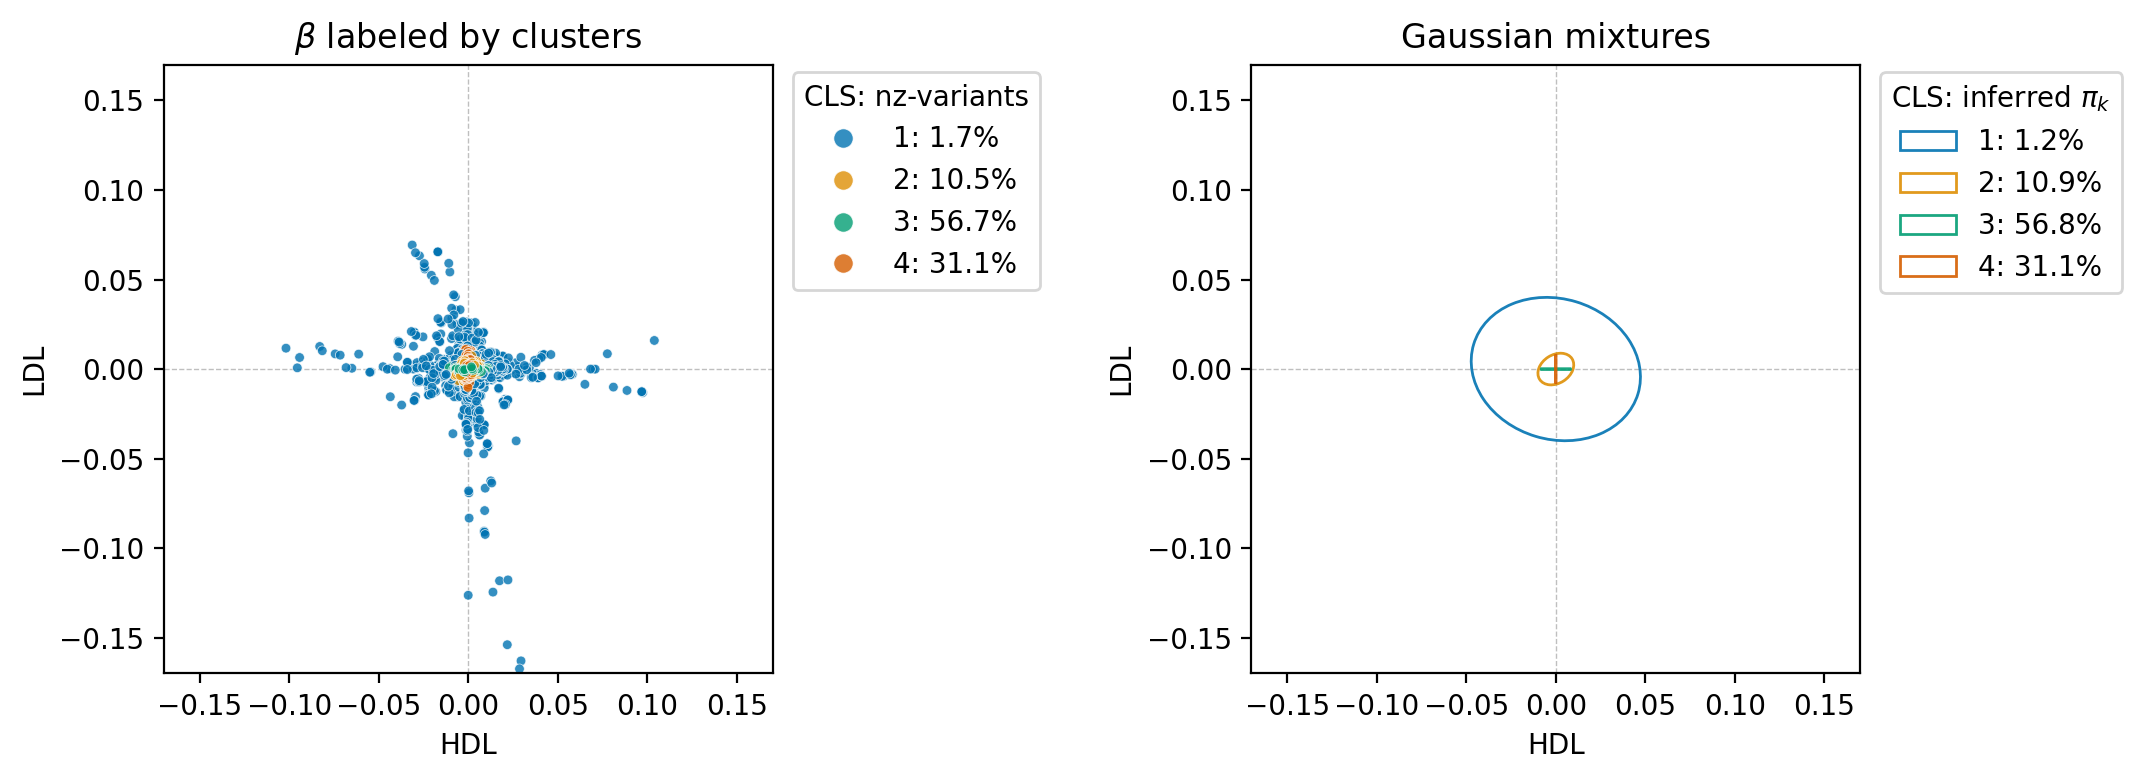

In [5]:
# Visualize clustering results (for bivariate analysis)
if n_traits==2:
    nz_idx = np.where(cls_lbs>=0)[0]
    fig = ml_mages.plot_clustering(betas[nz_idx,:], cls_lbs[nz_idx], pred_K, Sigma, pi, traits, "")

## Process outputs and analyze inferred clusters

In [6]:
# Compute eigen-info, and get the length/angle of axis of each Gaussian covariance
axis_lengths = list()
axis_angles = list()
for i, covar in enumerate(Sigma):
    # Calculate the eigenvectors and eigenvalues
    eigenval, eigenvec = np.linalg.eig(covar)
    idx = eigenval.argsort()[::-1]   
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:,idx]

    axis_lengths.append(eigenval)
     # compute angle to each axis
    angles_covar = list()
    for vec in eigenvec:
        angles = [angle_between(vec, np.eye(1,vec.shape[0], k=i).squeeze()) for i in range(vec.shape[0])]
        angles_covar.append(angles)
    angles_covar = np.array(angles_covar)
    axis_angles.append(angles_covar)

In [7]:
# Determine if each cluster is trait-specific using their Gaussian covariance
axis_specific_patterns = [np.array([is_axis_specific(angle, tol_deg=5) for angle in a]) for a in axis_angles]
axis_angles_deg = [np.rad2deg(a) for a in axis_angles]
is_trait_specific = list()
for i_a, axis_l in enumerate(axis_lengths):
    res = -1
    if np.all(axis_specific_patterns[i_a]==-1):
        res = -1
    else:
        # if an axis has length >> the others (by looking at their ratio)
        l_ratios = np.array([np.abs(l/axis_l) for l in axis_l])
        large_ratio_cnt = np.sum(l_ratios>100, axis=1)
        for idx in np.where(large_ratio_cnt==n_traits-1)[0]:
            if axis_specific_patterns[i_a][idx]>-1:
                res = axis_specific_patterns[i_a][idx]
    is_trait_specific.append(res)
is_trait_specific = np.array(is_trait_specific)

axis_large_patterns = [np.array([is_axis_specific(angle, tol_deg=45) for angle in a]) for a in axis_angles]
is_trait_large = list()
for i_a, axis_l in enumerate(axis_lengths):
    res = []
    # if an axis has length > the others (by looking at their ratio)
    l_ratios = np.array([np.abs(l/axis_l) for l in axis_l])
    large_ratio_cnt = np.sum(l_ratios>100, axis=1)
    for idx in np.where(large_ratio_cnt>=1)[0]:
        if axis_large_patterns[i_a][idx]>-1:
            res.append(axis_large_patterns[i_a][idx])
    is_trait_large.append(res)

In [9]:
# Select genes of interest
g_size_min = 20
all_cls_prop = 0.9
frac_columns = ['cls{}_frac'.format(i_cls+1) for i_cls in range(pred_K)]
var_interested = ((df_all[frac_columns].sum(axis=1)>=all_cls_prop)  & (df_all['N_SNPS']>=g_size_min)) #| (df_gene['is.sig.1'] | df_gene['is.sig.2'])
print("total number of genes to look at:", np.sum(var_interested))

total number of genes to look at: 33


## Visualize results

/tmp/ipykernel_1658320/908927654.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_1658320/908927654.py:72: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


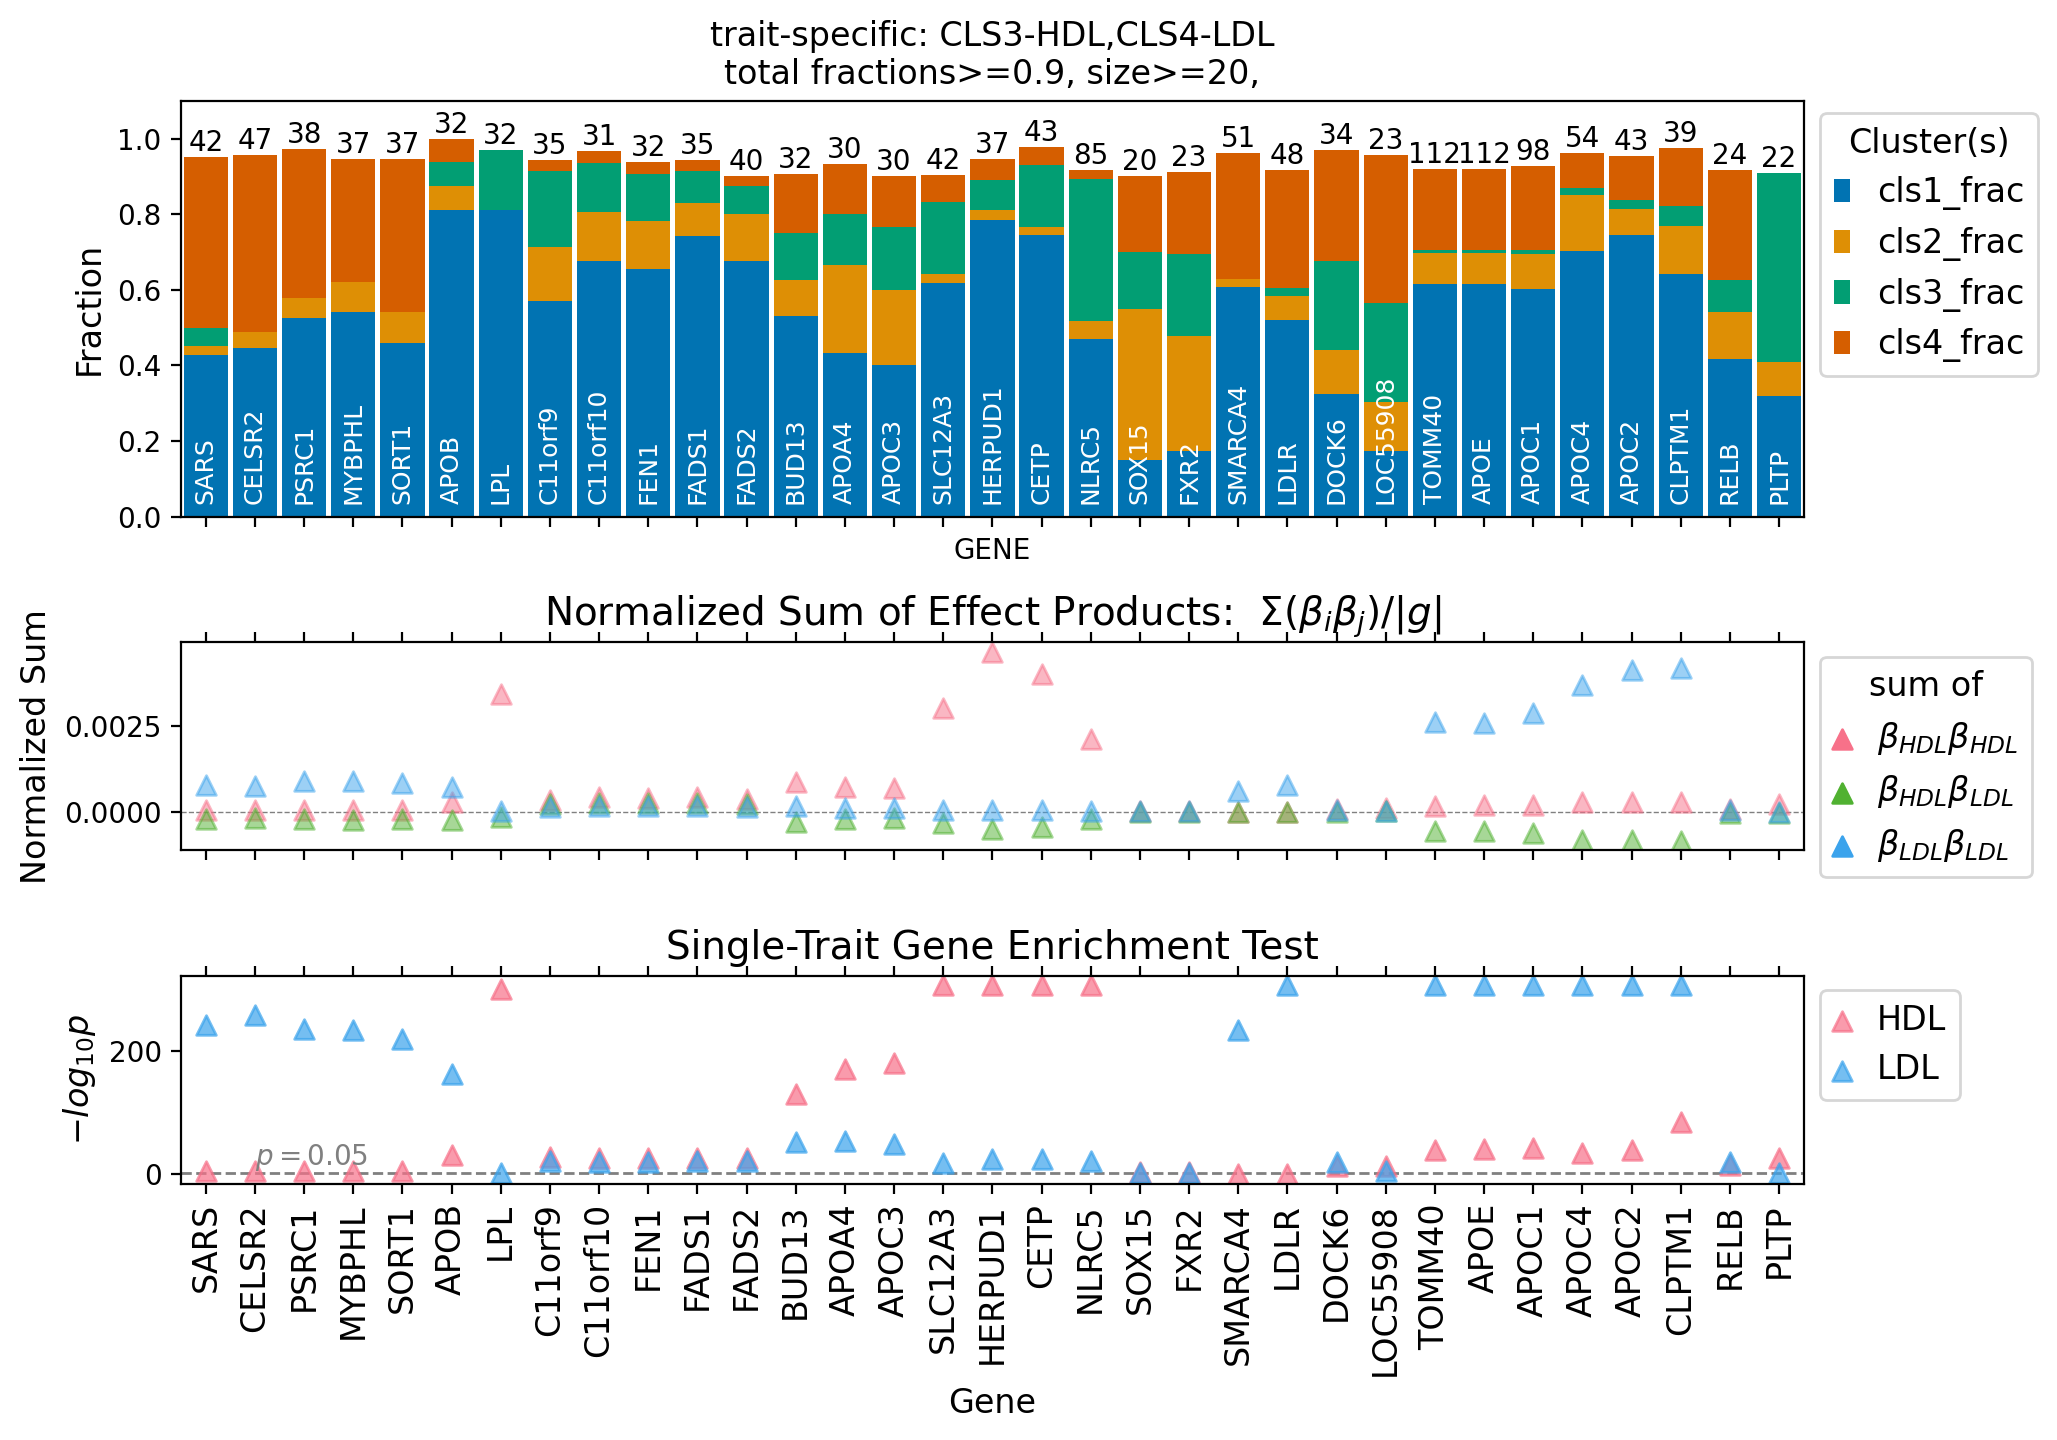

In [10]:
palette = sns.color_palette("colorblind", pred_K)
palette2 = sns.color_palette("husl", n_traits*(n_traits+1)//2)
fig, axes = plt.subplots(3,1,figsize=(10+(np.sum(var_interested)-30)//10,7), 
                         sharex=False, height_ratios=[0.5,0.25,0.25], dpi=200)

# panel A: fraction of variants in each cluster
ax = axes[0]
df_frac = df_all[var_interested][frac_columns]
df_frac.plot(kind='bar', stacked=True, color=palette, ax=ax, width=0.9)
frac_sum = df_frac.sum(axis=1)
for idx in np.arange(len(frac_sum)):
    ax.text(idx,frac_sum.values[idx],
            df_all[var_interested]['N_SNPS'].values[idx], 
            ha='center', va='bottom', fontsize=10)  
ax.set_xlim([-0.5,len(df_frac)-0.5])
ax.set_ylim([0,1.1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticks(np.arange(len(df_frac)))
ax.set_xticklabels(df_all[var_interested].index, rotation=90, 
                   va="bottom", color='white', fontsize=9)
ax.tick_params(axis='x', which='major', pad=-8)
ax.set_title("Fraction of Variants in Cluster(s)", fontsize=14)
ax.set_ylabel("Fraction", fontsize=12)
ax.legend(title="Cluster(s)", fontsize=12, title_fontsize=12, 
          handlelength=0.5, bbox_to_anchor=(1.0,1.01), loc="upper left")
sig_cls_info = "trait-specific: {}".format(",".join(["CLS{}-{}".format(s+1,traits[is_trait_specific[s]]) for s in np.where(is_trait_specific>=0)[0]]))
ax.set_title(sig_cls_info+"\ntotal fractions>={}, size>={},".format(all_cls_prop,g_size_min))

# panel B: normalized sum of effect products
ax = axes[1]
all_pw_comb = list(itertools.combinations_with_replacement(np.arange(n_traits), r=2))
pw_idx = 0
for i_1,i_2 in all_pw_comb:
    ax.scatter(x=np.arange(len(df_all[var_interested])), 
               y = df_all[var_interested]['b{}b{}'.format(i_1+1,i_2+1)],
               marker='^',linewidth=1, s=50, alpha=0.5,
               color=palette2[pw_idx], label="$\\beta_{"+traits[i_1]+"}\\beta_{"+traits[i_2]+"}$")
    pw_idx += 1
ax.set_title(r"Normalized Sum of Effect Products:  $\Sigma(\beta_i\beta_j)/|g|$", fontsize=14)
ax.set_ylabel("Normalized Sum", fontsize=12)
ax.set_xlim([-0.5,len(df_frac)-0.5])
ax.set_xticks(np.arange(len(df_frac)))
ax.axhline(0, ls='--', lw=0.5, c='gray', zorder=0)
ax.set_xticklabels([])
if pw_idx>4:
    ncols=2
else:
    ncols=1
ax.legend(title="sum of", ncols=ncols, fontsize=12, title_fontsize=12, columnspacing=0.5,
          handlelength=0.5, bbox_to_anchor=(1.0,1.01), loc="upper left")
ax.tick_params(top=True, labeltop=False, bottom=True, labelbottom=False)
leg = ax.legend_ 
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# panel C: single-trait enrichment analysis
ax = axes[2]
for i_trait, trait in enumerate(traits):
    ax.scatter(x=np.arange(len(df_all[var_interested])), 
               y = -np.log10(df_all[var_interested]['{}_P'.format(trait)]),
               marker='^',linewidth=1,
               color=palette2[(i_trait+1)*(i_trait+2)//2-1], s=50, alpha=0.7, label=trait)
ax.set_title("Single-Trait Gene Enrichment Test", fontsize=14)
ax.set_ylabel("$-log_{10}p$", fontsize=12)
ax.set_xlim([-0.5,len(df_frac)-0.5])
ax.set_xticks(np.arange(len(df_frac)))
ax.set_xticklabels(df_all[var_interested].index, rotation=90, fontsize=12)
ax.legend(bbox_to_anchor=(1.0,1.01), loc="upper left", fontsize=14)
ax.tick_params(top=True, labeltop=False, bottom=True, labelbottom=True)
leg = ax.legend_ 
for lh in leg.legendHandles: 
    lh.set_alpha(1)
sig_threshold = 0.05
ax.axhline(-np.log10(sig_threshold), ls='--', lw=1, c='gray', zorder=0)
ax.text(1,-np.log10(sig_threshold)+1,r"$p=0.05$",
        c='gray', ha="left",va="bottom", fontsize=10)
ax.set_xlabel("Gene", fontsize=12)
ax.legend(fontsize=12, title_fontsize=12, 
          handlelength=0.5, bbox_to_anchor=(1.0,1.01), loc="upper left")

fig.tight_layout(pad=0, w_pad=0.05, h_pad=1)
pass